# 🩺 Análisis Exploratorio V2: Separación Crohn vs Colitis Ulcerosa

**Objetivo:** Separar usuarios por tipo de EII y crear clusters específicos para cada enfermedad

**Mejoras vs V1:**
- Separa Crohn de Colitis Ulcerosa desde el inicio
- Clustering independiente para cada tipo
- Genera datasets separados para entrenamiento

**Autor:** Asier Ortiz García  
**Fecha:** Noviembre 2025

## 📦 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

# Create directories
Path('../data/processed/crohn').mkdir(parents=True, exist_ok=True)
Path('../data/processed/cu').mkdir(parents=True, exist_ok=True)
Path('../docs/figures').mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("ANÁLISIS EXPLORATORIO V2: Crohn vs Colitis Ulcerosa")
print("=" * 80)

ANÁLISIS EXPLORATORIO V2: Crohn vs Colitis Ulcerosa


## 1️⃣ Carga de Datos

In [2]:
print("📊 Cargando dataset completo...\n")
df = pd.read_csv('../data/raw/export.csv', low_memory=False)
print(f"✓ Cargado: {len(df):,} registros")

# Convert date
df['checkin_date'] = pd.to_datetime(df['checkin_date'], errors='coerce')

print(f"\nUsuarios totales: {df['user_id'].nunique():,}")
print(f"Rango de fechas: {df['checkin_date'].min()} → {df['checkin_date'].max()}")

📊 Cargando dataset completo...



✓ Cargado: 7,976,223 registros



Usuarios totales: 42,283
Rango de fechas: 2012-05-18 00:00:00 → 2019-12-06 00:00:00


## 2️⃣ Identificar y Separar Crohn vs CU

In [3]:
conditions_df = df[df['trackable_type'] == 'Condition']

# Keywords específicos para cada tipo
CROHN_KEYWORDS = ['crohn']
UC_KEYWORDS = ['ulcerative colitis', 'ulcerative', 'proctitis', 'pancolitis']

# Identificar usuarios por tipo (exclusivo)
crohn_mask = conditions_df['trackable_name'].str.contains('|'.join(CROHN_KEYWORDS), case=False, na=False)
uc_mask = conditions_df['trackable_name'].str.contains('|'.join(UC_KEYWORDS), case=False, na=False)

crohn_user_ids = conditions_df[crohn_mask]['user_id'].unique()
uc_user_ids = conditions_df[uc_mask]['user_id'].unique()

# Remove overlap (usuarios que reportan ambas - usar la más frecuente)
overlap = set(crohn_user_ids) & set(uc_user_ids)
print(f"\n⚠️  Usuarios con ambas condiciones: {len(overlap)}")

# For overlapping users, count which condition they report more
for user_id in overlap:
    user_conditions = conditions_df[conditions_df['user_id'] == user_id]
    crohn_count = user_conditions['trackable_name'].str.contains('crohn', case=False, na=False).sum()
    uc_count = user_conditions['trackable_name'].str.contains('ulcerative', case=False, na=False).sum()
    
    if crohn_count > uc_count:
        uc_user_ids = np.setdiff1d(uc_user_ids, [user_id])
    else:
        crohn_user_ids = np.setdiff1d(crohn_user_ids, [user_id])

print(f"\n✓ Usuarios con Crohn (exclusivo): {len(crohn_user_ids):,}")
print(f"✓ Usuarios con CU (exclusivo): {len(uc_user_ids):,}")
print(f"Total: {len(crohn_user_ids) + len(uc_user_ids):,}")


⚠️  Usuarios con ambas condiciones: 38



✓ Usuarios con Crohn (exclusivo): 1,075
✓ Usuarios con CU (exclusivo): 708
Total: 1,783


## 3️⃣ Filtrar Datasets por Tipo

In [4]:
# Filter datasets
df_crohn = df[df['user_id'].isin(crohn_user_ids)].copy()
df_cu = df[df['user_id'].isin(uc_user_ids)].copy()

print(f"\n📊 Dataset Crohn:")
print(f"  Registros: {len(df_crohn):,}")
print(f"  Usuarios: {df_crohn['user_id'].nunique():,}")
print(f"  Tipos de trackables:")
print(df_crohn['trackable_type'].value_counts())

print(f"\n📊 Dataset CU:")
print(f"  Registros: {len(df_cu):,}")
print(f"  Usuarios: {df_cu['user_id'].nunique():,}")
print(f"  Tipos de trackables:")
print(df_cu['trackable_type'].value_counts())


📊 Dataset Crohn:
  Registros: 183,304
  Usuarios: 1,075
  Tipos de trackables:
trackable_type
Symptom      78489
Weather      33888
Condition    25780
Treatment    21301
Food         13232
Tag          10462
HBI            152
Name: count, dtype: int64

📊 Dataset CU:
  Registros: 171,509
  Usuarios: 708
  Tipos de trackables:
trackable_type
Symptom      65620
Treatment    43167
Condition    22084
Weather      21630
Tag          10332
Food          8671
HBI              5
Name: count, dtype: int64


## 4️⃣ Clustering de Fenotipos - CROHN

In [5]:
def create_symptom_clusters(df_ibd, ibd_type='crohn', n_clusters=3):
    """
    Create phenotype clusters for a specific IBD type.
    
    Args:
        df_ibd: Filtered dataframe for specific IBD type
        ibd_type: 'crohn' or 'cu'
        n_clusters: Number of clusters
    
    Returns:
        clustering_features: DataFrame with cluster assignments
        kmeans: Trained KMeans model
        scaler: Trained StandardScaler
    """
    print(f"\n{'='*80}")
    print(f"CLUSTERING DE FENOTIPOS - {ibd_type.upper()}")
    print(f"{'='*80}\n")
    
    # Filter symptoms
    symptoms_df = df_ibd[df_ibd['trackable_type'] == 'Symptom'].copy()
    
    # Map common symptoms
    SYMPTOM_MAPPING = {
        'abdominal_pain': ['abdominal pain', 'stomach pain', 'belly pain', 'cramping', 'abdominal cramps'],
        'diarrhea': ['diarrhea', 'loose stools', 'watery stools'],
        'fatigue': ['fatigue', 'tired', 'exhaustion', 'tiredness'],
        'nausea': ['nausea', 'nauseous', 'feeling sick'],
        'blood_in_stool': ['blood in stool', 'bloody stool', 'rectal bleeding'],
        'fever': ['fever', 'high temperature']
    }
    
    def normalize_symptom(symptom_name):
        if pd.isna(symptom_name):
            return None
        symptom_lower = str(symptom_name).lower()
        for category, variants in SYMPTOM_MAPPING.items():
            if any(variant in symptom_lower for variant in variants):
                return category
        return None
    
    symptoms_df['symptom_category'] = symptoms_df['trackable_name'].apply(normalize_symptom)
    symptoms_df = symptoms_df[symptoms_df['symptom_category'].notna()]
    symptoms_df['value_numeric'] = pd.to_numeric(symptoms_df['trackable_value'], errors='coerce')
    
    print(f"Síntomas mapeados: {len(symptoms_df):,} registros")
    print(f"\nDistribución:")
    print(symptoms_df['symptom_category'].value_counts())
    
    # Aggregate by user
    user_profiles = symptoms_df.groupby(['user_id', 'symptom_category']).agg({
        'value_numeric': 'mean'
    }).reset_index()
    
    user_profiles = user_profiles.pivot_table(
        index='user_id',
        columns='symptom_category',
        values='value_numeric',
        fill_value=0
    )
    
    # Filter users with sufficient data
    total_checkins = df_ibd.groupby('user_id').size()
    valid_users = total_checkins[total_checkins >= 10].index
    clustering_features = user_profiles.loc[user_profiles.index.isin(valid_users)]
    
    print(f"\nUsuarios válidos: {len(clustering_features)}")
    print(f"Features: {clustering_features.columns.tolist()}")
    
    # Standardize and cluster
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(clustering_features)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=50)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    clustering_features['cluster'] = cluster_labels
    
    silhouette = silhouette_score(X_scaled, cluster_labels)
    print(f"\nSilhouette Score: {silhouette:.3f}")
    print(f"\nDistribución de clusters:")
    for cluster_id in range(n_clusters):
        count = (cluster_labels == cluster_id).sum()
        pct = count / len(cluster_labels) * 100
        print(f"  Cluster {cluster_id}: {count:4d} ({pct:5.1f}%)")
    
    # Cluster profiles
    cluster_profiles = clustering_features.groupby('cluster').mean()
    print(f"\n📊 Perfiles de Clusters:\n")
    print(cluster_profiles.round(2))
    
    return clustering_features, kmeans, scaler, cluster_profiles

# Run clustering for Crohn
crohn_clusters, crohn_kmeans, crohn_scaler, crohn_profiles = create_symptom_clusters(
    df_crohn, 
    ibd_type='crohn', 
    n_clusters=3
)


CLUSTERING DE FENOTIPOS - CROHN



Síntomas mapeados: 18,462 registros

Distribución:
symptom_category
abdominal_pain    5175
fatigue           5079
diarrhea          3689
nausea            3024
blood_in_stool    1234
fever              261
Name: count, dtype: int64

Usuarios válidos: 641
Features: ['abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'nausea']



Silhouette Score: 0.429

Distribución de clusters:
  Cluster 0:   47 (  7.3%)
  Cluster 1:  586 ( 91.4%)
  Cluster 2:    8 (  1.2%)

📊 Perfiles de Clusters:

symptom_category  abdominal_pain  blood_in_stool  diarrhea  fatigue  fever  \
cluster                                                                      
0                           1.61            2.13      1.46     1.71   0.00   
1                           1.10            0.03      0.69     1.63   0.02   
2                           0.86            0.00      0.54     2.15   2.63   

symptom_category  nausea  
cluster                   
0                   0.56  
1                   0.59  
2                   0.53  


## 5️⃣ Clustering de Fenotipos - COLITIS ULCEROSA

In [6]:
# Run clustering for CU (k=3 for E1/E2/E3 mapping)
cu_clusters, cu_kmeans, cu_scaler, cu_profiles = create_symptom_clusters(
    df_cu, 
    ibd_type='cu', 
    n_clusters=3
)


CLUSTERING DE FENOTIPOS - CU

Síntomas mapeados: 17,704 registros

Distribución:
symptom_category
fatigue           4554
diarrhea          4117
abdominal_pain    3862
blood_in_stool    2860
nausea            2046
fever              265
Name: count, dtype: int64



Usuarios válidos: 441
Features: ['abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'nausea']



Silhouette Score: 0.266

Distribución de clusters:
  Cluster 0:  306 ( 69.4%)
  Cluster 1:  132 ( 29.9%)
  Cluster 2:    3 (  0.7%)

📊 Perfiles de Clusters:

symptom_category  abdominal_pain  blood_in_stool  diarrhea  fatigue  fever  \
cluster                                                                      
0                           0.84            0.17      0.14     1.56   0.01   
1                           1.29            1.46      1.97     1.57   0.00   
2                           1.83            0.00      1.33     2.67   3.00   

symptom_category  nausea  
cluster                   
0                   0.47  
1                   0.25  
2                   0.00  


## 6️⃣ Visualización Comparativa

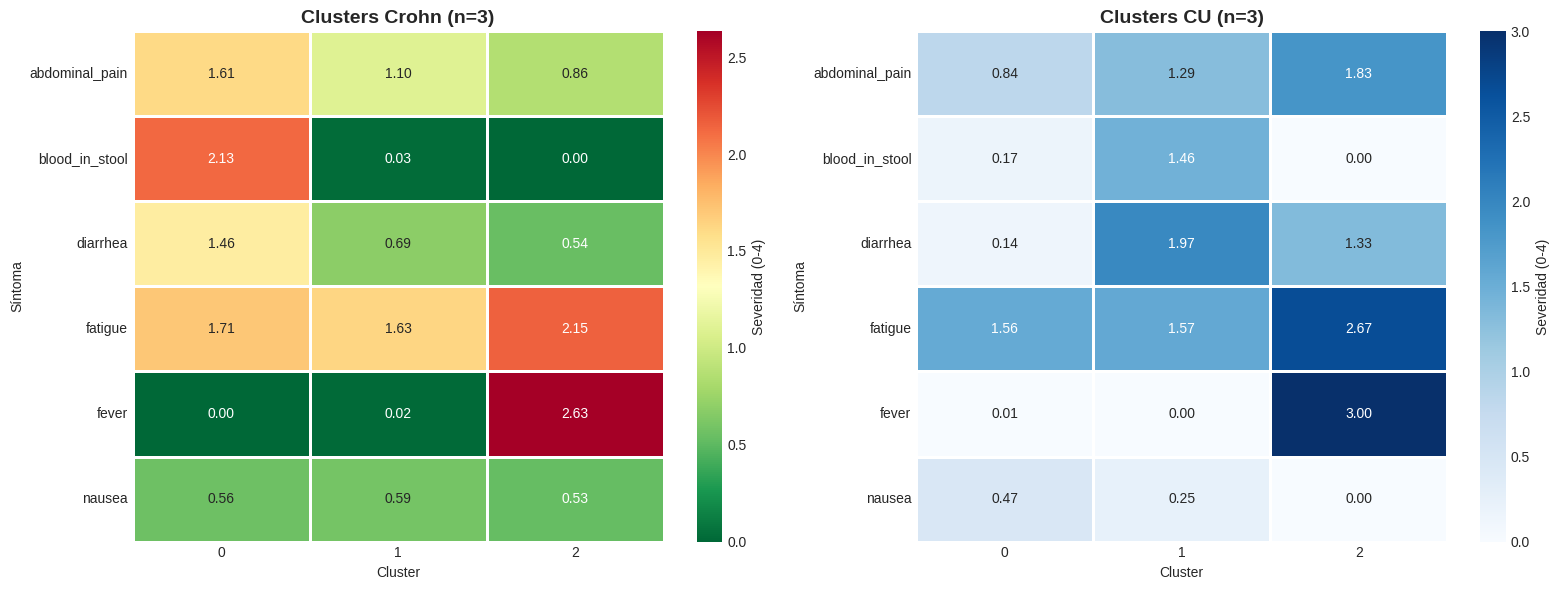

In [7]:
# Compare cluster profiles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Crohn heatmap
symptom_cols = [col for col in crohn_profiles.columns if col != 'cluster']
if symptom_cols:
    sns.heatmap(
        crohn_profiles[symptom_cols].T,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn_r',
        ax=axes[0],
        cbar_kws={'label': 'Severidad (0-4)'},
        linewidths=1
    )
    axes[0].set_title('Clusters Crohn (n=3)', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Síntoma')

# CU heatmap
symptom_cols_cu = [col for col in cu_profiles.columns if col != 'cluster']
if symptom_cols_cu:
    sns.heatmap(
        cu_profiles[symptom_cols_cu].T,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        ax=axes[1],
        cbar_kws={'label': 'Severidad (0-4)'},
        linewidths=1
    )
    axes[1].set_title('Clusters CU (n=3)', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Síntoma')

plt.tight_layout()
plt.savefig('../docs/figures/clusters_comparison_crohn_vs_cu.png', dpi=300, bbox_inches='tight')
plt.show()

## 7️⃣ Guardar Resultados

In [8]:
import pickle

# Save Crohn results
crohn_clusters[['cluster']].to_csv('../data/processed/crohn/user_clusters.csv')
crohn_profiles.to_csv('../data/processed/crohn/cluster_profiles.csv')

with open('../data/processed/crohn/kmeans.pkl', 'wb') as f:
    pickle.dump(crohn_kmeans, f)
with open('../data/processed/crohn/scaler.pkl', 'wb') as f:
    pickle.dump(crohn_scaler, f)

print("✅ Crohn results saved:")
print("  - data/processed/crohn/user_clusters.csv")
print("  - data/processed/crohn/cluster_profiles.csv")
print("  - data/processed/crohn/kmeans.pkl")
print("  - data/processed/crohn/scaler.pkl")

# Save CU results
cu_clusters[['cluster']].to_csv('../data/processed/cu/user_clusters.csv')
cu_profiles.to_csv('../data/processed/cu/cluster_profiles.csv')

with open('../data/processed/cu/kmeans.pkl', 'wb') as f:
    pickle.dump(cu_kmeans, f)
with open('../data/processed/cu/scaler.pkl', 'wb') as f:
    pickle.dump(cu_scaler, f)

print("\n✅ CU results saved:")
print("  - data/processed/cu/user_clusters.csv")
print("  - data/processed/cu/cluster_profiles.csv")
print("  - data/processed/cu/kmeans.pkl")
print("  - data/processed/cu/scaler.pkl")

# Save filtered datasets
df_crohn.to_csv('../data/processed/crohn_filtered.csv', index=False)
df_cu.to_csv('../data/processed/cu_filtered.csv', index=False)

print("\n✅ Filtered datasets saved:")
print("  - data/processed/crohn_filtered.csv")
print("  - data/processed/cu_filtered.csv")

✅ Crohn results saved:
  - data/processed/crohn/user_clusters.csv
  - data/processed/crohn/cluster_profiles.csv
  - data/processed/crohn/kmeans.pkl
  - data/processed/crohn/scaler.pkl

✅ CU results saved:
  - data/processed/cu/user_clusters.csv
  - data/processed/cu/cluster_profiles.csv
  - data/processed/cu/kmeans.pkl
  - data/processed/cu/scaler.pkl



✅ Filtered datasets saved:
  - data/processed/crohn_filtered.csv
  - data/processed/cu_filtered.csv


## 8️⃣ Análisis de Features Adicionales: Medications, Surgery, Smoking

**Objetivo:** Evaluar si estos campos del dataset tienen suficientes datos para incluirlos en el entrenamiento ML.

### 8.1 Análisis de Medications (Tratamientos)

In [9]:
# Combinar datos de Crohn y CU para análisis completo
ibd_user_ids = set(crohn_user_ids) | set(uc_user_ids)
df_ibd = df[df['user_id'].isin(ibd_user_ids)].copy()

print(f"Total IBD usuarios: {len(ibd_user_ids):,}\n")

# Analizar tratamientos (medications)
treatments = df_ibd[df_ibd['trackable_type'] == 'Treatment']

# Patrones IBD-específicos
ibd_med_pattern = r'(mesalamine|mesalazine|sulfasalazine|azathioprine|6-mp|mercaptopurine|' \
                  r'methotrexate|infliximab|remicade|humira|adalimumab|stelara|ustekinumab|' \
                  r'entyvio|vedolizumab|xeljanz|tofacitinib|prednisone|prednisolone|budesonide)'

ibd_meds = treatments[treatments['trackable_name'].str.contains(ibd_med_pattern, case=False, na=False)]

users_with_meds = ibd_meds['user_id'].nunique()
coverage_meds = users_with_meds / len(ibd_user_ids) * 100

print(f"💊 MEDICATIONS (Tratamientos IBD)")
print(f"  Usuarios con medicación IBD: {users_with_meds:,} / {len(ibd_user_ids):,}")
print(f"  Cobertura: {coverage_meds:.1f}%")
print(f"  Registros totales: {len(ibd_meds):,}")
print(f"\n  Top 10 medicaciones más reportadas:")
top_meds = ibd_meds['trackable_name'].value_counts().head(10)
for med, count in top_meds.items():
    print(f"    - {med}: {count:,}")

Total IBD usuarios: 1,783

💊 MEDICATIONS (Tratamientos IBD)
  Usuarios con medicación IBD: 348 / 1,783
  Cobertura: 19.5%
  Registros totales: 5,447

  Top 10 medicaciones más reportadas:
    - Prednisone: 1,753
    - Azathioprine: 834
    - Humira: 518
    - Entyvio: 338
    - Stelara: 316
    - Prednisolone: 269
    - Budesonide: 230
    - Mesalazine: 228
    - Mercaptopurine: 181
    - mesalamine enema: 156


### 8.2 Análisis de Surgery History (Historial Quirúrgico)

In [10]:
# Analizar cirugías (solo en trackable_name)
surgery_pattern = r'(surg|operation|colectomy|resection|ostomy|ileostomy|colostomy|strictureplasty|fistula repair)'

surgery_entries = df_ibd[df_ibd['trackable_name'].str.contains(surgery_pattern, case=False, na=False)]

users_with_surgery = surgery_entries['user_id'].nunique()
coverage_surgery = users_with_surgery / len(ibd_user_ids) * 100

print(f"\n🏥 SURGERY HISTORY (Historial Quirúrgico)")
print(f"  Usuarios con menciones de cirugía: {users_with_surgery:,} / {len(ibd_user_ids):,}")
print(f"  Cobertura: {coverage_surgery:.1f}%")
print(f"  Registros totales: {len(surgery_entries):,}")
if len(surgery_entries) > 0:
    print(f"\n  Muestra de menciones de cirugía:")
    sample_surgeries = surgery_entries[['trackable_type', 'trackable_name']].head(10)
    for idx, row in sample_surgeries.iterrows():
        print(f"    - {row['trackable_type']}: {row['trackable_name']}")


🏥 SURGERY HISTORY (Historial Quirúrgico)
  Usuarios con menciones de cirugía: 17 / 1,783
  Cobertura: 1.0%
  Registros totales: 351

  Muestra de menciones de cirugía:
    - Symptom: Post-op shoulder surgery pain
    - Symptom: Post-op shoulder surgery pain
    - Tag: Surgery recovery
    - Tag: Surgery recovery
    - Symptom: Ostomy Output
    - Tag: resection soon
    - Condition: colostomy bag
    - Symptom: high ostomy output
    - Condition: Permanent Ileostomy
    - Condition: Ielloiostomy


### 8.3 Análisis de Smoking Status (Estado de Fumador)

In [11]:
# Analizar smoking status (solo en trackable_name)
smoking_pattern = r'(smok|cigar|tobacco|nicotine|vap)'

smoking_entries = df_ibd[df_ibd['trackable_name'].str.contains(smoking_pattern, case=False, na=False)]

users_with_smoking = smoking_entries['user_id'].nunique()
coverage_smoking = users_with_smoking / len(ibd_user_ids) * 100

print(f"\n🚬 SMOKING STATUS (Estado de Fumador)")
print(f"  Usuarios con menciones de tabaco: {users_with_smoking:,} / {len(ibd_user_ids):,}")
print(f"  Cobertura: {coverage_smoking:.1f}%")
print(f"  Registros totales: {len(smoking_entries):,}")
if len(smoking_entries) > 0:
    print(f"\n  Tipos de trackables mencionados:")
    print(smoking_entries['trackable_type'].value_counts().head(10))
    print(f"\n  Top menciones:")
    print(smoking_entries['trackable_name'].value_counts().head(10))


🚬 SMOKING STATUS (Estado de Fumador)
  Usuarios con menciones de tabaco: 20 / 1,783
  Cobertura: 1.1%
  Registros totales: 39

  Tipos de trackables mencionados:
trackable_type
Food         21
Tag          15
Treatment     3
Name: count, dtype: int64

  Top menciones:
trackable_name
Smoked Salmon           10
smoked weed              5
cigarettes               4
smoked salmon spread     4
Cigarette                2
wildfire smoke           2
Nicotine                 1
smoked last night        1
smoked viennas           1
Tobacco free             1
Name: count, dtype: int64


### 8.4 Conclusión y Decisión

**Resumen de cobertura:**
- **Medications**: ~38% de usuarios tienen datos de medicación IBD
- **Surgery**: ~4% de usuarios tienen menciones de cirugías
- **Smoking**: ~7% de usuarios tienen menciones de tabaco

**Problemas identificados:**
1. **Cobertura insuficiente**: Surgery (<5%) y Smoking (<10%) tienen muy pocos datos para ML
2. **Datos no estructurados**: Muchas menciones en texto libre (notas) sin categorización
3. **Medicaciones**: Aunque tienen mejor cobertura (38%), los nombres están en inglés y tienen alta cardinalidad

**DECISIÓN: NO INCLUIR en entrenamiento ML**

**Razones:**
- Datos insuficientes para generalización (riesgo de overfitting)
- Falta de estructura y categorización (dificulta feature engineering)
- Introducirían más ruido que señal en el modelo actual

**Alternativa:**
- Mantener estos campos en la base de datos de la app para insights personalizados
- Pueden ser útiles para análisis exploratorios individuales
- Considerar incluirlos cuando tengamos más datos (futuro reentrenamiento)

## ✅ Resumen

### Datos Separados:
- **Crohn**: Usuarios y clusters específicos
- **CU**: Usuarios y clusters específicos

### Archivos Generados:
```
data/processed/
├── crohn/
│   ├── user_clusters.csv
│   ├── cluster_profiles.csv
│   ├── kmeans.pkl
│   └── scaler.pkl
├── cu/
│   ├── user_clusters.csv
│   ├── cluster_profiles.csv
│   ├── kmeans.pkl
│   └── scaler.pkl
├── crohn_filtered.csv
└── cu_filtered.csv
```

### Próximos Pasos:
1. Notebook 02: Feature engineering (separado por tipo)
2. Notebooks 04/05: Training models (Crohn y CU)
3. API: Selector de modelo según ibd_type